# Forecasting Influenza with Internet Traffic
### Purpose of this notebook
* Explore the feasability of using linear models for epidemiological forecasting
* In specific, to use Wikipedia Pageview logs to train linear models that can forecast weekly ILI in the United States

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn import linear_model
%matplotlib inline

### Retrieving Relevant Data from Data Store

In [2]:
%run influenza-data.ipynb
%store -r pageViews
%store -r wILI

Found pageViewResps
Found wILIresp
Found pageViews
Found wILI
Found epiweeksDf


### DataFrame Format Reference

In [3]:
pageViews[:2]

,influenza_pandemic,cough,nasal_congestion,fatigue_(medical),hemagglutinin_(influenza),chills,influenza_a_virus_subtype_h5n1,influenza_a_virus_subtype_h7n7,human_flu,influenza_a_virus_subtype_h2n2,...,neuraminidase_inhibitor,influenza_a_virus_subtype_h7n9,shivering,oseltamivir,influenza_prevention,cat_flu,common_cold,orthomyxoviridae,viral_neuraminidase,influenza_a_virus_subtype_h1n2
200801,1030,7600,3981,957,0,777,218,6,350,155,...,362,0,1251,1124,0,319,19240,565,0,14
200802,1642,8972,3722,1045,0,858,304,12,453,205,...,461,0,1299,1501,0,339,21084,885,0,19


In [4]:
wILI[:2]

,Weekly ILI
200801,2.254048
200802,2.091472


## Simple Linear Regression
Have data from 2008-2016. I will use **6 years for training (2008-2013), 3 years for validating (2014-2016)**

In [5]:
wILItrain = np.array(wILI.loc[200801:201352])
wILItest = np.array(wILI.loc[201401:201652])

wILItrain = wILItrain.reshape(len(wILItrain), 1)
wILItest = wILItest.reshape(len(wILItest), 1)

### Finding Most Highly Correlated Articles
Using the Pearson coefficient

In [91]:
pearsonCoefs = []
for article in pageViews.columns:
    df = pd.DataFrame({'wILI': wILI['Weekly ILI'].values,
                       'Views': pageViews[article].values})
    pearsonCoefs.append( (article, df.corr().loc['Views', 'wILI'] ) )
pearsonCoefs.sort(key=lambda t: t[1], reverse=True) # sort by pearson coeff
pearsonCoefs[:10] # top 10

[('influenza_a_virus', 0.63450513478840198),
 ('influenza_prevention', 0.43605492425828085),
 ('flu_season', 0.41945066734649017),
 ('influenza', 0.41666222785105261),
 ('influenza_a_virus_subtype_h1n2', 0.40999249521206299),
 ('influenza_vaccine', 0.37589161673363947),
 ('oseltamivir', 0.37359017238211584),
 ('common_cold', 0.3525967831122489),
 ('viral_pneumonia', 0.34392147569674275),
 ('influenza_a_virus_subtype_h1n1', 0.33120886165169416)]

### Simple Linear Regression On Each Article

Coefficients: 
 [[ 0.00155694]]
Mean squared error: 0.77
Variance score: 0.10


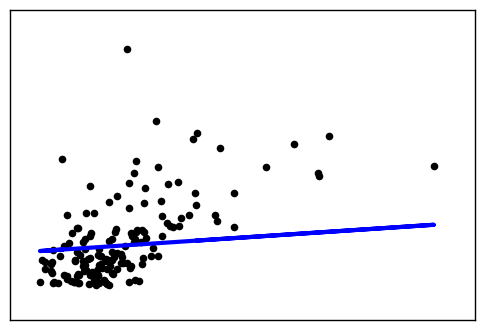

In [35]:
minMSE, bestArticle = float("inf"), None

# find article that best predicts wILI
for article in pageViews.columns:
    pageViewsTrain = np.array(pageViews.loc[200801:201352, [article] ] )
    pageViewsTest = np.array(pageViews.loc[201401:201652, [article] ])
    # reshape for compatability with sklearn
    pageViewsTrain = pageViewsTrain.reshape(len(pageViewsTrain), 1)
    pageViewsTest = pageViewsTest.reshape(len(pageViewsTest), 1)
    
    regr = linear_model.LinearRegression()
    regr.fit(pageViewsTrain, wILItrain)
    
    thisMSE = np.mean((regr.predict(pageViewsTest) - wILItest) ** 2)

    if thisMSE < minMSE:
        minMSE, bestArticle = minMSE, article

pageViewsTrain = np.array(pageViews.loc[200801:201352, bestArticle])
pageViewsTest = np.array(pageViews.loc[201401:201652, bestArticle])
# reshape for compatability with sklearn
pageViewsTrain = pageViewsTrain.reshape(len(pageViewsTrain), 1)
pageViewsTest = pageViewsTest.reshape(len(pageViewsTest), 1)

regr = linear_model.LinearRegression()
regr.fit(pageViewsTrain, wILItrain)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(pageViewsTest) - wILItest) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(pageViewsTest, wILItest))

# Plot outputs
plt.scatter(pageViewsTest, wILItest,  color='black')
plt.plot(pageViewsTest, regr.predict(pageViewsTest), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

### Multiple Linear Regression On Most Highly Correlated Articles

In [92]:
selectedArticles = [ t[0] for t in pearsonCoefs[:10] ]
pageViewsTrain = np.array(pageViews.loc[ 200801:201352, selectedArticles])
pageViewsTest = np.array(pageViews.loc[201401:201652, selectedArticles])

regr = linear_model.LinearRegression()
regr.fit(pageViewsTrain, wILItrain)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(pageViewsTest) - wILItest) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(pageViewsTest, wILItest))

Coefficients: 
 [[  1.64458320e-04   6.74082094e-04  -2.17993899e-04  -1.11483304e-06
    2.66669665e-04  -5.07088319e-05   1.95149196e-05   7.75766421e-05
    5.37796884e-05   9.67395960e-06]]
Mean squared error: 0.87
Variance score: -0.02
